In [2]:
t_end = 'Now'
duration_in_day = 30

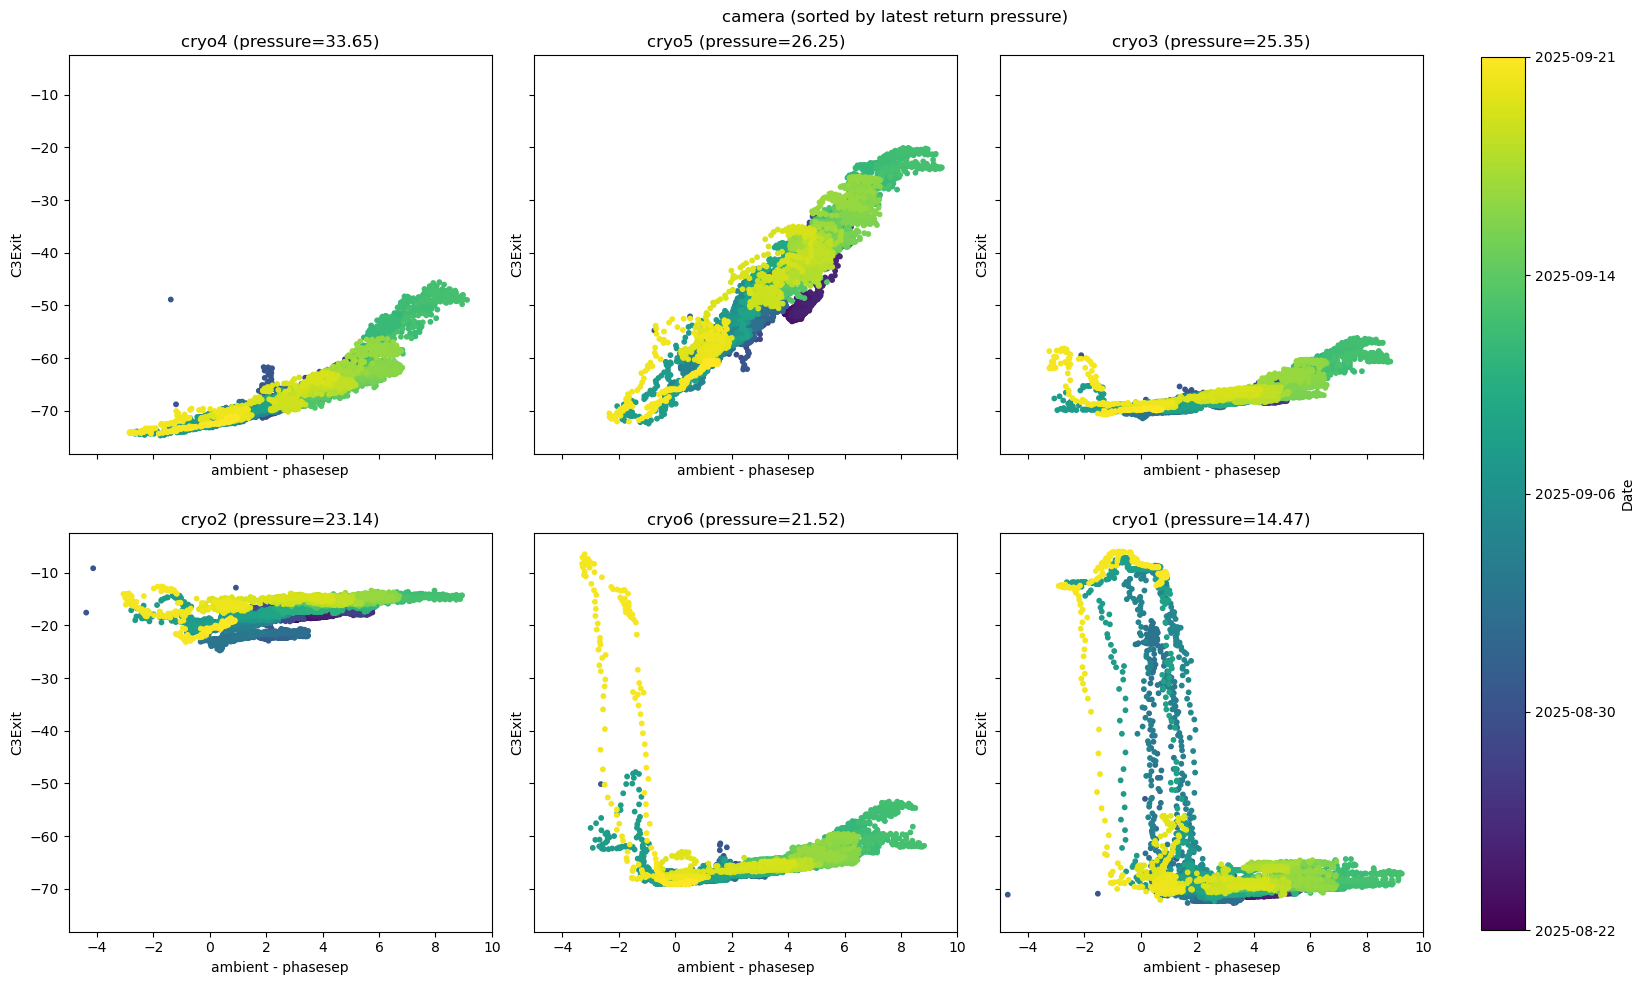

In [9]:
# Scatter plots for c3exit vs ambient-phasesep for all cryo units, sorted by latest return pressure (descending), colored by date
from lsst_efd_client import EfdClient
from datetime import datetime, timezone
from dateutil.parser import parse
from astropy.time import Time, TimeDelta
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

client = EfdClient("usdf_efd")

# Prepare time range
if t_end == 'Now':
    t_end_val = Time.now()
else:
    t_end_val = Time(t_end)
t_start_val = t_end_val - TimeDelta(duration_in_day, format='jd')
t_start_iso = t_start_val.iso
t_end_iso = t_end_val.iso

ambientkey = 'camera'
hextempkey = 'C3Exit'
pressurekey = 'mean_pressure'

# Get latest return pressure for each cryo unit
latest_pressures = []
pressure_dict = {}
for i in range(6):
    cryo = f'cryo{i+1}'
    query_pressure = f'''
    SELECT mean("pressure") AS "{pressurekey}"
    FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.hex_cryo_pressure"
    WHERE time > '{t_start_iso}' AND time < '{t_end_iso}'
      AND "Source"='Return'
      AND "Cryo"='{cryo}'
    GROUP BY time(5m) FILL(null)
    '''
    pressure_df = await client.influx_client.query(query_pressure)
    if pressurekey in pressure_df.columns and not pressure_df.empty:
        latest_value = pressure_df[pressurekey].dropna().iloc[-1]
        latest_pressures.append((cryo, latest_value))
        pressure_dict[cryo] = latest_value
    else:
        latest_pressures.append((cryo, np.nan))
        pressure_dict[cryo] = np.nan

# Sort cryo units by latest pressure (descending, NaN last)
sorted_cryos = [x[0] for x in sorted(latest_pressures, key=lambda x: (np.isnan(x[1]), -x[1] if not np.isnan(x[1]) else float('-inf')))]

if ambientkey == 'camera':
    ambient_query = f'''
    SELECT mean("AmbAirtemp") AS "ambient"
    FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.utiltrunk_body"
    WHERE time > '{t_start_iso}' AND time < '{t_end_iso}'
      AND "Agent"='utiltrunk'
    GROUP BY time(5m) FILL(null)
    '''
else:
    ambient_query = f'''
    SELECT mean("temperature") AS "ambient"
    FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.refrig_cryo_temp"
    WHERE time > '{t_start_iso}' AND time < '{t_end_iso}'
      AND "Source"='Ambient'
      AND "Cryo"='cryo1'
      AND "Agent"='refrig2'
    GROUP BY time(5m) FILL(null)
    '''
ambient = await client.influx_client.query(ambient_query)

fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)
axes = axes.flatten()

all_time_numeric = None

# First pass: collect all time values for color normalization
for cryo in sorted_cryos:
    query_c3exit = f'''
    SELECT mean("temperature") AS "{hextempkey}"
    FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.hex_cryo_temp"
    WHERE time > '{t_start_iso}' AND time < '{t_end_iso}'
      AND "Source"='{hextempkey}'
      AND "Cryo"='{cryo}'
    GROUP BY time(5m) FILL(null)
    '''
    c3exit = await client.influx_client.query(query_c3exit)
    query_phasesep = f'''
    SELECT mean("temperature") AS "phasesep"
    FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.refrig_cryo_temp"
    WHERE time > '{t_start_iso}' AND time < '{t_end_iso}'
      AND "Source"='PhaseSep'
      AND "Cryo"='{cryo}'
      AND "Agent"='refrig2'
    GROUP BY time(5m) FILL(null)
    '''
    phasesep = await client.influx_client.query(query_phasesep)
    df = pd.concat([c3exit, phasesep, ambient], axis=1)
    dates = pd.to_datetime(df.index).tz_convert('UTC')
    time_numeric = dates.astype(np.int64)
    if all_time_numeric is None:
        all_time_numeric = time_numeric
    else:
        all_time_numeric = np.concatenate([all_time_numeric, time_numeric])

# Second pass: plot with shared color normalization (by date)
norm = plt.Normalize(all_time_numeric.min(), all_time_numeric.max())
cmap = plt.get_cmap('viridis')

for idx, cryo in enumerate(sorted_cryos):
    query_c3exit = f'''
    SELECT mean("temperature") AS "{hextempkey}"
    FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.hex_cryo_temp"
    WHERE time > '{t_start_iso}' AND time < '{t_end_iso}'
      AND "Source"='{hextempkey}'
      AND "Cryo"='{cryo}'
    GROUP BY time(5m) FILL(null)
    '''
    c3exit = await client.influx_client.query(query_c3exit)
    query_phasesep = f'''
    SELECT mean("temperature") AS "phasesep"
    FROM "lsst.MTCamera"."autogen"."lsst.MTCamera.refrig_cryo_temp"
    WHERE time > '{t_start_iso}' AND time < '{t_end_iso}'
      AND "Source"='PhaseSep'
      AND "Cryo"='{cryo}'
      AND "Agent"='refrig2'
    GROUP BY time(5m) FILL(null)
    '''
    phasesep = await client.influx_client.query(query_phasesep)
    df = pd.concat([c3exit, phasesep, ambient], axis=1)
    dates = pd.to_datetime(df.index).tz_convert('UTC')
    x = df['ambient'] - df['phasesep']
    y = df[hextempkey]
    time_numeric = dates.astype(np.int64)
    axes[idx].scatter(x, y, c=time_numeric, cmap='viridis', norm=norm, s=10)
    axes[idx].set_title(f'{cryo} (pressure={pressure_dict[cryo]:.2f})')
    axes[idx].set_xlabel('ambient - phasesep')
    axes[idx].set_ylabel(hextempkey)
    axes[idx].set_xlim(-5,10)

plt.suptitle(f'{ambientkey} (sorted by latest return pressure)')
plt.tight_layout()
plt.subplots_adjust(right=0.85, wspace=0.1, hspace=0.2)

sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, orientation='vertical', fraction=0.03, pad=0.04)
cbar.set_label('Date')
tick_locs = np.linspace(all_time_numeric.min(), all_time_numeric.max(), num=5)
tick_labels = pd.to_datetime(tick_locs).strftime('%Y-%m-%d')
if tick_labels[0] > tick_labels[-1]:
    tick_locs = tick_locs[::-1]
    tick_labels = tick_labels[::-1]
cbar.set_ticks(tick_locs)
cbar.set_ticklabels(tick_labels)

plt.show()
